In [1]:
# !pip install gingado fredapi umap ruptures hdbscan shap torch WordCloud scikit-network keybert datasets
# !pip install tiktoken openai transformers sentence_transformers ctransformers bertopic vertexai sentencepiece

# !pip install -U 'spacy[apple]'
# # !pip install -U 'spacy[cuda12x]'

# # !pip install numpy==2.1.3 --force-reinstall --no-cache-dir

In [322]:
import os
from dotenv import load_dotenv; load_dotenv()

from tqdm.notebook import tqdm
import pickle
from numba import njit
import pandas as pd
import numpy as np
from numpy.linalg import eig
import numpy.typing as npt
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.lines as mlines
from wordcloud import WordCloud
from itertools import chain
from tabulate import tabulate

from datasets import load_dataset

import umap
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity as cosine

import re
import unicodedata
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"
import torch
import gc
import spacy; spacy.prefer_gpu()
import tiktoken
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from vertexai.preview import tokenization
from transformers import pipeline, AutoTokenizer, AutoModel, AutoModelForTokenClassification
from ctransformers import AutoModelForCausalLM
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from bertopic.representation._openai import OpenAI as BertOpenAI
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

import networkx as nx
from sknetwork.clustering import Leiden
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix
from scipy.sparse import block_diag, hstack, vstack
from sklearn.neighbors import kneighbors_graph
from keybert import KeyBERT
from transformers.pipelines import pipeline

from cdm.helpers import spacy as spacy_helpers
from cdm.helpers.openai_api import OPENAI_CLIENT, OpenAIEmbedding
from cdm.helpers.openai_api import chat_completion as openai_chat
from cdm.helpers.google_ai_api import GGENAI_CLIENT, GoogleAIEmbedding, AdvancedGoogleAIEmbedding
from cdm.helpers.google_ai_api import chat_completion as gemini_chat

In [ ]:
DATA_PATH = os.getenv("DATA_PATH", "data")

FRED_API = os.getenv("FRED_API_KEY")
DEVICE = torch.device("mps")
STOP_WORDS = list(ENGLISH_STOP_WORDS)
RANDOM_STATE = 42

START_DATE = '1996-01-01'
END_DATE = '2025-05-01'

# Transformer Narrative Polarity Fields: Capturing Multidimensional Semantic Shifts with TOPOL

**Abstract**:
In computational linguistics, semantic polarity has traditionally been referred to sentiment expressed along a scalar continuum. However, language polarity is multidimensional, as semantic spaces are as direction-rich as perspectives of discourse captured in a given narrative context. We here introduce an unsupervised computational framework for capturing the multidimensionality of semantic polarity by reconstructing and explaining topic-shift transformer vector polarity fields. We model discourse evolution as vector displacements in semantic transformer embedding spaces, and reconstruct narrative polarity vectors on top of state-of-the-art topic modeling extracted manifolds. These polarity vectors both capture the narrative polarity field of the discourse, that could be or not sentiment-aligned, and are able to represent the direction and magnitude of semantic change across a contextual boundary defining the polarity-relevant narrative dimension. We apply this computational framework to the mapping and detection of central bank speech narrative fields and shifts that occur at macroeconomic regime changes. This robust unsupervised framework constitutes the first computational formulation for reconstructing polarity vector fields and mapping the multidimensional dynamics of narrative polarity semantic spaces.

# Helpers

In [4]:
def softmax(x, T=1):
    x = x / T
    return np.exp(x) / np.sum(np.exp(x))

In [5]:
def sigmoid(p1, p0, k):
    return 1 / ( 1 + np.exp( -k * (p1 - p0) ) )

In [6]:
def _clean_mps_cache():
    gc.collect()
    if torch.backends.mps.is_available():
        torch.mps.empty_cache()

---
---
---

# Text Pre-processing

### Getting data: 5-stars reviews

In [7]:
"""
1. Amazon Reviews (Multi-Domain)
    ✅ Millions of product reviews
    ✅ Multiple categories (Books, Electronics, etc.)
    ✅ Each review has text and a 1–5 rating
"""
dataset = load_dataset("amazon_polarity")

# """
# 2. Yelp Reviews
#     ✅ Balanced opinions, strong language contrast
#     ✅ Natural clusters (food, service, price)
#     ✅ Polished writing, informal style
# """
# dataset = load_dataset("yelp_review_full")

# """
# 3. IMDB Reviews
#     ✅ Clean binary sentiment classification
#     ✅ High semantic polarity: sarcasm, emotion, style
# """
# dataset = load_dataset("imdb")

# """
# 4. Google Play Store Reviews
#     ✅ Millions of reviews
#     ✅ Multiple categories (Games, Productivity, etc.)
#     ✅ Each review has text and a 1–5 rating
# """
# dataset = load_dataset("google_play_store_reviews")

In [8]:
# text = combined title and text
X_train = [f"{title} {text}" for title, text in zip(dataset['train']['title'], dataset['train']['content'])]
X_test = [f"{title} {text}" for title, text in zip(dataset['test']['title'], dataset['test']['content'])]

y_train = dataset['train']['label']
y_test = dataset['test']['label']

In [9]:
data = pd.DataFrame({ 'text': X_train, 'label': y_train })

In [10]:
len(data[data['label'] == 1]), len(data[data['label'] == 0])

(1800000, 1800000)

In [11]:
N_SAMPLE = 5000

df_A = data[data['label'] == 1].sample(N_SAMPLE, random_state=RANDOM_STATE)
df_B = data[data['label'] == 0].sample(N_SAMPLE, random_state=RANDOM_STATE)
df = pd.concat([df_A, df_B], axis=0).reset_index(drop=True)

In [12]:
df

,text,label
0,Perfect Mantra I've been looking for this mant...,1
1,Quality I'm just a little disapointed with the...,1
2,Exceptional murder-mystery writer scores big. ...,1
3,all the prodding questions you never wanted to...,1
4,Best Wok ever I am so glad I bought this wok. ...,1
...,...,...
9995,Doesn't work for me While I applaud the focus ...,0
9996,Beyond Stupid One wonders about all the people...,0
9997,Buyer Be Very Wary The trusted leader in child...,0
9998,I'll bring earplugs to the state fair next yea...,0


### Pre-processing data

1. Data cleaning

In [13]:
stop_words = STOP_WORDS

try:
    entity_detection = spacy.load("en_core_web_sm")
except:
    print("Downloading the spaCy model...")
    spacy_helpers.install_spacy_model(lang='en', pipeline_for="sm")
    entity_detection = spacy.load("en_core_web_sm")

def clean_text(text: str) -> str:

    # 0. Remove newlines and special characters
    text = text.replace('\n', ' ')
    text = text.replace('\r', ' ')
    text = text.replace('\t', ' ')
    text = text.replace('\\', ' ')

    # 1. Normalize Unicode
    text = unicodedata.normalize("NFKC", text)
    
    # 2. Remove non-informative patterns
    text = re.sub(r'\s+', ' ', text)        # normalize whitespace
    text = re.sub(r'[•◦▪●]', '', text)      # remove bullet symbols
    text = re.sub(r'[_*~^]+', '', text)     # remove markdown / symbol clutter

    # 3. Mask entities (dates, times, locations, names and organizations)
    entities = entity_detection(text).ents
    for ent in entities:
        if ent.label_ == "DATE" and ent.text.lower() not in ['today', 'tomorrow', 'yesterday']:
            text = text.replace(ent.text, 'DATE')
        elif ent.label_ == "TIME":
            text = text.replace(ent.text, 'TIME')
        elif ent.label_ == "GPE":
            text = text.replace(ent.text, 'LOCATION')
        # elif ent.label_ == "PERSON":
        #     text = text.replace(ent.text, 'PERSON')
        elif ent.label_ == "ORG":
            text = text.replace(ent.text, 'ORGANIZATION')

    # 4. Mask percentages and numbers
    text = re.sub(r'\b\d+(\.\d+)?%?\b', 'NUM', text)

    # 5. Strip leading/trailing whitespace
    text = text.strip()

    return text


def get_clean_text(row, max_lenght=20000) -> str:
    text = row['text']
    text = clean_text(text)
    words = text.split()
    if len(words) > max_lenght:
        text = ' '.join(words[:max_lenght])
    return text

def get_clean_texts(df: pd.DataFrame, max_lenght=20000, verbose=False) -> list:
    documents = []
    if verbose:
        for i, row in tqdm(df.iterrows(), total=len(df)):
            document = get_clean_text(row, max_lenght=max_lenght)
            documents.append(document)
    else:
        return df.apply(get_clean_text, axis=1, max_lenght=max_lenght).values.tolist()
    
    return documents
STOP_WORDS += ["DATE", "TIME", "PERSON", "ORGANIZATION", "NUM", "LOCATION"]

In [14]:
df["document"] = get_clean_texts(df, max_lenght=5000, verbose=True)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [18]:
MODEL_NAME = "text-embedding-3-small"                       # OpenAI
# MODEL_NAME = "text-embedding-004"                         # Google Gemini
# MODEL_NAME = 'intfloat/multilingual-e5-large-instruct'    # HuggingFace

EMBEDDING_MODEL = OpenAIEmbedding(model=MODEL_NAME)
# EMBEDDING_MODEL = GoogleAIEmbedding(model=MODEL_NAME)
# EMBEDDING_MODEL = AdvancedGoogleAIEmbedding(model='text-embedding-004', task='clustering')
# EMBEDDING_MODEL = SentenceTransformer(MODEL_NAME, device=DEVICE)

fpath = "data/embeddings_TOPOL.pickle"
if os.path.exists(fpath):
    print(f"Loading embeddings from {fpath}")
    with open(fpath, "rb") as f:
        embeddings = pickle.load(f)
    print(f"Loaded {len(embeddings)} embeddings")
else:
    print(f"Generating embeddings for {len(df)} documents...")
    embeddings = EMBEDDING_MODEL.encode(df["document"].tolist(), fast=False)
    with open(fpath, "wb") as f:
        pickle.dump(embeddings, f)
    print(f"Saved {len(embeddings)} embeddings to {fpath}.")

df["embedding"] = embeddings.tolist()

Loading embeddings from data/embeddings_TOPOL.pickle
Loaded 10000 embeddings


In [19]:
df

,text,label,document,embedding
0,Perfect Mantra I've been looking for this mant...,1,Perfect Mantra I've been looking for this mant...,"[0.028224848210811615, 0.03228772059082985, -0..."
1,Quality I'm just a little disapointed with the...,1,Quality I'm just a little disapointed with the...,"[0.025785230100154877, -0.010898678563535213, ..."
2,Exceptional murder-mystery writer scores big. ...,1,Exceptional murder-mystery writer scores big. ...,"[0.012370972894132137, 0.03619104251265526, -0..."
3,all the prodding questions you never wanted to...,1,all the prodding questions you never wanted to...,"[-0.001434302655979991, 0.027779487892985344, ..."
4,Best Wok ever I am so glad I bought this wok. ...,1,Best Wok ever I am so glad I bought this wok. ...,"[-0.0065714335069060326, -0.06777285784482956,..."
...,...,...,...,...
9995,Doesn't work for me While I applaud the focus ...,0,Doesn't work for me While I applaud the focus ...,"[0.01933857798576355, 0.04882385581731796, 0.0..."
9996,Beyond Stupid One wonders about all the people...,0,Beyond Stupid One wonders about all the people...,"[0.0016734168166294694, 0.037151455879211426, ..."
9997,Buyer Be Very Wary The trusted leader in child...,0,Buyer Be Very Wary The trusted leader in child...,"[0.02373512089252472, -0.017155539244413376, 0..."
9998,I'll bring earplugs to the state fair next yea...,0,I'll bring earplugs to the state fair DATE... ...,"[-0.00831352174282074, 0.004247289150953293, -..."


### Sentiment analysis

In [20]:
def get_sentiment_id(sentiments):
    probabilities = [sentiments["negative"], sentiments["neutral"], sentiments["positive"]]
    max_prob = max(probabilities)
    return probabilities.index(max_prob) - 1

def transform_output(output):
    return { s['label']: s['score'] for s in output }

def split_into_token_chunks(text, tokenizer, max_length=512, length_delta=10, stride=0):
    """
    Splits a text into chunks of at most `max_length` tokens using a for loop (no truncation).
    
    Args:
        text (str): Input text.
        tokenizer: HuggingFace tokenizer.
        max_length (int): Max number of tokens per chunk.
        length_delta (int): Security margin for the chunk length (optional).
        stride (int): Overlap between chunks (optional).
    
    Returns:
        List[str]: List of text chunks.
    """
    max_length -= length_delta
    encoding = tokenizer(text, return_offsets_mapping=True, add_special_tokens=False)
    input_ids = encoding["input_ids"]
    offsets = encoding["offset_mapping"]

    if len(input_ids) <= max_length:
        return [text]

    chunks = []
    step = max_length - stride if stride else max_length
    for start in range(0, len(input_ids), step):
        end = min(start + max_length, len(input_ids))
        start_offset = offsets[start][0]
        end_offset = offsets[end - 1][1]
        chunk_text = text[start_offset:end_offset]
        chunks.append(chunk_text)

    return chunks

def get_sentiment(text, tokenizer, sentiment_model, batch_size=16, max_length=512, length_delta=10, stride=0):
    chunks = split_into_token_chunks(text, tokenizer, max_length, length_delta, stride)
    if len(chunks) == 1:
        return transform_output(sentiment_model(chunks[0])[0])

    # Get average positive, negative, neutral probabilities
    sentiments = sentiment_model(chunks, verbose=True, max_length=max_length, truncation=False, batch_size=batch_size)
    sentiments = [transform_output(s) for s in sentiments]
    return {
        "positive": np.mean([s["positive"] for s in sentiments]),
        "negative": np.mean([s["negative"] for s in sentiments]),
        "neutral": np.mean([s["neutral"] for s in sentiments])
    }

In [400]:
sentiment_model_name = "tabularisai/multilingual-sentiment-analysis"
# sentiment_model_name = "siebert/sentiment-roberta-large-english"
sentiment_model = pipeline('sentiment-analysis', model=sentiment_model_name, top_k=None, device=DEVICE)
max_length = sentiment_model.tokenizer.model_max_length

sentiments = []
for idx, row in tqdm(df.iterrows(), total=len(df)):
    doc = row['document']
    temp_sentiment = get_sentiment(doc, sentiment_model.tokenizer, sentiment_model, batch_size=16, max_length=max_length)
    sentiments.append(temp_sentiment)
df["sentiment"] = sentiments

Device set to use mps


  0%|          | 0/10000 [00:00<?, ?it/s]

### Polarity score

In [402]:
# https://www.alpha-sense.com/blog/engineering/sentiment-score/
# https://help.sesamm.com/article/32-sentiment-polarity
# https://help.sesamm.com/article/32-sentiment-polarity

def sentiment_to_polarity(sentiment):
    p_pos = sentiment["Very Positive"] + sentiment["Positive"]
    p_neg = sentiment["Very Negative"] + sentiment["Negative"]
    p_neu = sentiment["Neutral"]
    return (p_pos - p_neg) / (p_pos + p_neg + p_neu)

# def sentiment_to_polarity(sentiment):
#     p_pos = sentiment["POSITIVE"]
#     p_neg = sentiment["NEGATIVE"]
#     return (p_pos - p_neg) / (p_pos + p_neg)

In [403]:
df["polarity"] = df["sentiment"].apply(sentiment_to_polarity)

---
---
---

# Polarity drift analysis: UMAP + Leiden clustering

Explain novelty and improvements here

In [ ]:
data_A = df[df["label"] == 1].copy()
data_B = df[df["label"] == 0].copy()

polarity_pos_reviews = data_A["polarity"].values
mean_pos = np.mean(polarity_pos_reviews)
polarity_neg_reviews = data_B["polarity"].values
mean_neg = np.mean(polarity_neg_reviews)

plt.figure(figsize=(10, 5))
plt.hist(polarity_pos_reviews, bins=50, alpha=0.5, label='Positive Reviews', color='blue')
plt.axvline(x=mean_pos, color='blue', linestyle='--', label='Mean Pos. Review Sentiment')
plt.hist(polarity_neg_reviews, bins=50, alpha=0.5, label='Negative Reviews', color='red')
plt.axvline(x=mean_neg, color='red', linestyle='--', label='Mean Neg. Review Sentiment')
plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()
plt.savefig("images/sentiment_score_frequency_amazon_reviews.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [284]:
embeddings.shape

(10000, 1536)

##### 1.2. Reduce dimension in A period anchored dimensional space

In [285]:
"""
UMAP parameters

- n_neighbors: Controls how UMAP balances local versus global structure in the data. Low values of n_neighbors will force UMAP to 
               concentrate on very local structure, while large values will push UMAP to look at larger neighborhoods of each point 
               when estimating the manifold structure of the data.

- min_dist: Controls how tightly UMAP is allowed to pack points together. It provides the minimum distance apart that points are 
            allowed to be in the low dimensional representation. This means that low values of min_dist will result in clumpier 
            embeddings. This can be useful if you are interested in clustering, or in finer topological structure. Larger values 
            of min_dist will prevent UMAP from packing points together and will focus on the preservation of the broad topological 
            structure instead.
"""

dim_reducer_params = {
    'n_neighbors': 100,
    'min_dist': 0.0,
    'metric': 'cosine',
    'transform_mode': "embedding",
    'random_state': RANDOM_STATE
}

dim_reducer = UMAP(n_components=50, **dim_reducer_params) # Dimensionality reduction used for clustering
vizualier = UMAP(n_components=2, **dim_reducer_params)          # Dimensionality reduction used only for visualization purposes

In [286]:
reduced_embeddings = dim_reducer.fit_transform(embeddings)
print(reduced_embeddings.shape)

graph = dim_reducer.graph_
print(graph.shape)

(10000, 50)
(10000, 10000)


In [287]:
embeddings_2D = vizualier.fit_transform(embeddings)
df["2D_embeddings"] = list(embeddings_2D)
print(embeddings_2D.shape)

(10000, 2)


##### 1.3 Clustering with Leiden

In [288]:
"""
Leiden parameters

- resolution: Controls the size (granularity) of the clusters. Higher values will result in more (small) clusters (= fine granularity), 
              while lower values will result in less (large) clusters (= coarser granularity). Recommended from 0.1 to 2.0

- modularity: Type of modularity to maximize. The default is "dugue".

- ...
"""

clusterer = Leiden(resolution=1.5, modularity="dugue", random_state=RANDOM_STATE)

In [289]:
adjacency_matrix = csr_matrix(graph)
print(adjacency_matrix.shape)
labels = clusterer.fit_predict(adjacency_matrix)
probs = clusterer.predict_proba()

df["cluster"] = labels
df["cluster_probs"] = probs.tolist()
print(f"Found {len(np.unique(labels, return_counts=False))} clusters.")

(10000, 10000)
Found 12 clusters.


##### 1.4 Compute cluster information per period: centroids and cluster representations

In [295]:
TOP_FREQ_N_WORDS = 20
TOP_REPR_DOCS = 10
TF_IDF_N_WORDS = 20
N_GRAMS_RANGE = (1, 2)
MAX_FEATURES = 10000
STOP_WORDS += ["date", "time", "person", "organization", "num"]

def get_top_n_words(documents: list, n: int=10) -> dict:
    vectorizer_model = CountVectorizer(stop_words=STOP_WORDS, ngram_range=N_GRAMS_RANGE, max_features=MAX_FEATURES)
    words = vectorizer_model.fit_transform(documents)
    words_freq = words.sum(axis=0).A1
    words_freq = [(word, words_freq[idx]) for word, idx in vectorizer_model.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return dict(words_freq[:n])

def get_top_n_representative_documents(documents: list, embeddings: list, centroid: np.array, n: int=10) -> list:
    assert len(documents) == len(embeddings) > 0, "Documents and embeddings must have the same length."
    assert centroid.shape[0] == embeddings[0].shape[0], f"Centroid and embeddings must have the same dimensionality: {centroid.shape[0]} != {embeddings[0].shape[0]}"
    sim_matrix = cosine(embeddings, centroid.reshape(1, -1))
    sim_matrix = sim_matrix.ravel()
    sorted_indices = np.argsort(sim_matrix)[::-1]
    top_n_indices = sorted_indices[:min(len(sorted_indices), n)]
    return [documents[i] for i in top_n_indices]

In [ ]:
cluster_info_A = pd.DataFrame({"Cluster": np.unique(labels[data_A.index])})
cluster_info_A["Count"] = cluster_info_A["Cluster"].map(data_A["cluster"].value_counts())
cluster_info_A["Top_Words"] = cluster_info_A["Cluster"].apply(
    lambda x: get_top_n_words(data_A[data_A["cluster"] == x]["document"].values.tolist(), n=TOP_FREQ_N_WORDS)
)
cluster_info_A["Polarity"] = cluster_info_A["Cluster"].apply(lambda x: data_A[data_A["cluster"] == x]["polarity"].mean())
cluster_info_A["Centroid"] = cluster_info_A["Cluster"].apply(
    lambda x: np.mean(data_A[data_A["cluster"] == x]['embedding'].tolist(), axis=0)
)
cluster_info_A["2D_Centroid"] = cluster_info_A["Cluster"].apply(
    lambda x: np.mean(data_A[data_A["cluster"] == x]['2D_embeddings'].tolist(), axis=0)
)
cluster_info_A["Top_Representative_Docs"] = cluster_info_A[["Cluster", "Centroid"]].apply(
    lambda x:
        get_top_n_representative_documents(
            data_A[data_A["cluster"] == x["Cluster"]]["document"].values.tolist(),
            np.stack(data_A[data_A["cluster"] == x["Cluster"]]['embedding'].values), 
            x["Centroid"],
            n=TOP_REPR_DOCS
        ),
        axis=1
)

cluster_info_B = pd.DataFrame({"Cluster": np.unique(labels[data_B.index])})
cluster_info_B["Count"] = cluster_info_B["Cluster"].map(data_B["cluster"].value_counts())
cluster_info_B["Top_Words"] = cluster_info_B["Cluster"].apply(
    lambda x: get_top_n_words(data_B[data_B["cluster"] == x]["document"].values.tolist(), n=TOP_FREQ_N_WORDS)
)
cluster_info_B["Polarity"] = cluster_info_B["Cluster"].apply(lambda x: data_B[data_B["cluster"] == x]["polarity"].mean())
cluster_info_B["Centroid"] = cluster_info_B["Cluster"].apply(
    lambda x: np.mean(data_B[data_B["cluster"] == x]['embedding'].tolist(), axis=0)
)
cluster_info_B["2D_Centroid"] = cluster_info_B["Cluster"].apply(
    lambda x: np.mean(data_B[data_B["cluster"] == x]['2D_embeddings'].tolist(), axis=0)
)
cluster_info_B["Top_Representative_Docs"] = cluster_info_B[["Cluster", "Centroid"]].apply(
    lambda x:
        get_top_n_representative_documents(
            data_B[data_B["cluster"] == x["Cluster"]]["document"].values.tolist(),
            np.stack(data_B[data_B["cluster"] == x["Cluster"]]['embedding'].values), 
            x["Centroid"],
            n=TOP_REPR_DOCS
        ),
        axis=1
)

In [ ]:
def get_tf_idf_top_n_words(documents: list, n: int=10):
    doc_strings = documents
    vectorizer_model = CountVectorizer(stop_words=STOP_WORDS, ngram_range=N_GRAMS_RANGE, max_features=MAX_FEATURES)
    X_counts = vectorizer_model.fit_transform(doc_strings)
    transformer = TfidfTransformer()
    X_tfidf = transformer.fit_transform(X_counts)
    feature_names = vectorizer_model.get_feature_names_out()
    sorted_indices = np.argsort(X_tfidf.toarray(), axis=1)[:, ::-1]
    top_n_words = []
    for i in range(X_tfidf.shape[0]):
        top_n_indices = sorted_indices[i, :n]
        top_n_words.append({feature_names[idx]: X_tfidf[i, idx] for idx in top_n_indices})
    return top_n_words

cluster_info_A["Top_Words_TFIDF"] = [[] for _ in range(len(cluster_info_A))]
cluster_info_B["Top_Words_TFIDF"] = [[] for _ in range(len(cluster_info_B))]
for cluster_id in cluster_info_A["Cluster"]:
    top_repr_doc_A = cluster_info_A[cluster_info_A["Cluster"] == cluster_id]["Top_Representative_Docs"].values[0]
    joined_top_repr_doc_A = " ".join(top_repr_doc_A)

    top_repr_doc_B = cluster_info_B[cluster_info_B["Cluster"] == cluster_id]["Top_Representative_Docs"].values[0]
    joined_top_repr_doc_B = " ".join(top_repr_doc_B)

    tf_idf_words_A_B = get_tf_idf_top_n_words([joined_top_repr_doc_A, joined_top_repr_doc_B], n=TOP_FREQ_N_WORDS)
    idx_A = cluster_info_A[cluster_info_A["Cluster"] == cluster_id].index[0]
    cluster_info_A.at[idx_A, "Top_Words_TFIDF"] = tf_idf_words_A_B[0]
    idx_B = cluster_info_B[cluster_info_B["Cluster"] == cluster_id].index[0]
    cluster_info_B.at[idx_B, "Top_Words_TFIDF"] = tf_idf_words_A_B[1]

In [352]:
cluster_info_A

,Cluster,Count,Top_Words,Polarity,Centroid,2D_Centroid,Top_Representative_Docs,Top_Words_TFIDF
0,0,894,"{'album': 659, 'cd': 617, 'great': 392, 'music...",0.085473,"[0.011528653549964903, -0.009146312230966035, ...","[-6.3510375, 11.735862]",[A Great CD!! I just brouth the cd DATE and i ...,"{'cd': 0.4376960581804727, 'love': 0.246066615..."
1,1,694,"{'movie': 665, 'great': 324, 'film': 251, 'goo...",0.064741,"[0.0029287492124572957, 0.028359161250688547, ...","[-3.3736017, 8.539618]",[ORGANIZATION This is a great family movie. My...,"{'movie': 0.27657539263816383, 'dvd': 0.197553..."
2,2,1073,"{'book': 1625, 'read': 774, 'location': 482, '...",0.049111,"[0.008987083655877873, 0.023067805010000615, -...","[-3.153183, 6.0792913]",[Awesome story! I read this book DATE and was ...,"{'book': 0.5241881079500057, 'read': 0.2970399..."
3,3,398,"{'great': 242, 'good': 163, 'use': 151, 'produ...",0.090212,"[0.0007687019474977561, -0.009997927761146663,...","[1.2845765, 11.5605545]",[ORGANIZATION !!!!! After looking at all the l...,"{'great': 0.2813633749895629, 'works': 0.12986..."
4,4,457,"{'book': 830, 'good': 187, 'great': 175, 'read...",0.062826,"[-0.0004267746146818133, 0.015042905003451729,...","[-2.0416512, 5.3528113]",[Well-written overview for savvy readers I did...,"{'book': 0.486603237147092, 'beauty': 0.148674..."
5,5,119,"{'book': 204, 'read': 97, 'good': 52, 'locatio...",-0.038864,"[0.0037254618489116964, 0.03576638240331956, -...","[-3.7672863, 5.4529085]",[Sad to see all of these one-star ratings I th...,"{'book': 0.39259818498534416, 'read': 0.215929..."
6,6,381,"{'great': 204, 'use': 136, 'good': 133, 'just'...",0.136553,"[-0.0035710792156105216, -0.001786078213120681...","[2.3827057, 10.398474]",[nothing like a quality utensil! I works as ad...,"{'easy': 0.1522830248093701, 'use': 0.15228302..."
7,7,297,"{'great': 137, 'good': 91, 'like': 77, 'love':...",0.055791,"[0.013598940783836945, 0.004470523168548067, -...","[1.2404929, 9.4590435]","[Great toy, but doesn't stand up on its own Th...","{'little': 0.325426605488476, 'kids': 0.271188..."
8,8,158,"{'great': 62, 'just': 45, 'good': 44, 'like': ...",0.108504,"[0.017070376055834217, -0.004159863194310006, ...","[1.1536223, 9.908058]",[LOVE THESE!!! I have been buying Reef flip fl...,"{'comfortable': 0.16535412522163156, 'great': ..."
9,9,295,"{'great': 163, 'product': 116, 'good': 98, 'li...",0.199283,"[0.006142117790616378, -0.006536695968965032, ...","[1.3735547, 9.7022295]",[Excellent Product! I heard about ORGANIZATION...,"{'product': 0.28050895854079894, 'location': 0..."


In [353]:
cluster_info_B

,Cluster,Count,Top_Words,Polarity,Centroid,2D_Centroid,Top_Representative_Docs,Top_Words_TFIDF
0,0,506,"{'cd': 306, 'album': 293, 'like': 275, 'music'...",-0.277759,"[0.0053725385951542476, 0.006491184748350638, ...","[-5.705087, 12.022892]",[NUM well crafted songs does NOT make a great ...,"{'cd': 0.30436871655316655, 'just': 0.19694446..."
1,1,694,"{'movie': 866, 'film': 306, 'like': 245, 'just...",-0.359910,"[-0.010633056993161537, 0.0414265474285979, -0...","[-3.851504, 9.032088]",[What the hell did I just watch. I am a true B...,"{'movie': 0.37448638726796957, 'didn': 0.13850..."
2,2,148,"{'book': 198, 'location': 131, 'read': 61, 'ju...",-0.126583,"[0.0036250250638192017, 0.03226543082033655, -...","[-3.2227294, 5.479171]","[Once again, Russo spreads lies to make a quic...","{'book': 0.40700837223395525, 'location': 0.23..."
3,3,743,"{'product': 277, 'work': 261, 'buy': 189, 'jus...",-0.289626,"[-0.011955829541034628, 0.007195871853782029, ...","[1.3370048, 11.608749]",[Won't stand by warranty ORGANIZATION shopping...,"{'unit': 0.3301553115063221, 'product': 0.2017..."
4,4,504,"{'book': 975, 'information': 136, 'good': 132,...",-0.214471,"[-0.007318436966497323, 0.025375927257755393, ...","[-2.3236804, 4.9330063]",[not worth the price. This product was a disap...,"{'book': 0.5885931886040904, 'waste': 0.142628..."
5,5,842,"{'book': 1432, 'read': 540, 'just': 303, 'like...",-0.316409,"[0.001981527392259542, 0.0420021092714336, -0....","[-3.881546, 5.000532]",[Very Disappointing I'm not sure where to star...,"{'book': 0.49640651618480125, 'read': 0.215109..."
6,6,388,"{'use': 121, 'just': 111, 'product': 99, 'wate...",-0.267222,"[-0.019170269255595222, 0.024261822090358185, ...","[2.466487, 10.579221]",[An adjustable disappointment When I first got...,"{'water': 0.17483836879001505, 'just': 0.15994..."
7,7,420,"{'product': 157, 'just': 105, 'toy': 101, 'lik...",-0.334084,"[-0.0018364903428250944, 0.02104540464389131, ...","[1.4964659, 10.003449]",[ORGANIZATION I bought DATE and just had to pu...,"{'product': 0.24965000502748322, 'bought': 0.1..."
8,8,398,"{'product': 141, 'ordered': 92, 'item': 85, 'j...",-0.247365,"[0.0004894000872379946, 0.005818653900174678, ...","[0.9395281, 10.18981]",[Very disapionted It is not a NUM-Cup size. It...,"{'product': 0.2036636032630175, 'ordered': 0.1..."
9,9,155,"{'product': 89, 'like': 56, 'hair': 51, 'good'...",-0.201236,"[-0.014313963731195057, 0.007266686875523338, ...","[2.1817398, 9.868083]",[ORGANIZATION at DATE the price I heard good t...,"{'product': 0.30511201422348183, 'hair': 0.239..."


a. Stylized dataframes

In [324]:
# cluster_info_A_refined = cluster_info_A.copy()
# cluster_info_A_refined.drop(columns=["Polarity", "Centroid", "2D_Centroid", "Top_Representative_Docs"], inplace=True)
# cluster_info_A_refined["Top_Words"] = cluster_info_A_refined["Top_Words"].apply(lambda x: ", ".join(x))
# cluster_info_A_refined["Top_Words_TFIDF"] = cluster_info_A_refined["Top_Words_TFIDF"].apply(lambda x: ", ".join(x))
# cluster_info_A_refined.rename(columns={
#     "Cluster": "Cluster ID",
#     "Count": "Size",
#     "Top_Words": f"Top {TOP_FREQ_N_WORDS} Most Freq. Words",
#     "Top_Words_TFIDF": f"Top {TF_IDF_N_WORDS} TF-IDF Words",
# }, inplace=True)
# cluster_info_A_refined.set_index("Cluster ID", inplace=True)
# styled_cluster_info_A_refined = cluster_info_A_refined.style
# styled_cluster_info_A_refined = styled_cluster_info_A_refined.set_table_styles([
#     {'selector': 'th', 'props': [('font-size', '18px'), ('padding', '12px')]},
#     {'selector': 'td.col_heading.level0', 'props': [('border-right', 'px solid black')]},  # Optional right border
#     {'selector': 'td.col_heading.level1', 'props': [('border-right', '2px solid black')]}
# ])

# latex_code = tabulate(cluster_info_A_refined, headers='keys', tablefmt='latex')
# with open("images/cluster_info_A_amazon.tex", "w") as f:
#     f.write(latex_code)

# styled_cluster_info_A_refined

In [325]:
# cluster_info_B_refined = cluster_info_B.copy()
# cluster_info_B_refined.drop(columns=["Polarity", "Centroid", "2D_Centroid", "Top_Representative_Docs"], inplace=True)
# cluster_info_B_refined["Top_Words"] = cluster_info_B_refined["Top_Words"].apply(lambda x: ", ".join(x))
# cluster_info_B_refined["Top_Words_TFIDF"] = cluster_info_B_refined["Top_Words_TFIDF"].apply(lambda x: ", ".join(x))
# cluster_info_B_refined.rename(columns={
#     "Cluster": "Cluster ID",
#     "Count": "Size",
#     "Top_Words": f"Top {TOP_FREQ_N_WORDS} Most Freq. Words",
#     "Top_Words_TFIDF": f"Top {TF_IDF_N_WORDS} TF-IDF Words",
# }, inplace=True)
# cluster_info_B_refined.set_index("Cluster ID", inplace=True)
# styled_cluster_info_B_refined = cluster_info_B_refined.style
# styled_cluster_info_B_refined = styled_cluster_info_B_refined.set_table_styles([
#     {'selector': 'th', 'props': [('font-size', '18px'), ('padding', '12px')]},
#     {'selector': 'td.col_heading.level0', 'props': [('border-right', 'px solid black')]},  # Optional right border
#     {'selector': 'td.col_heading.level1', 'props': [('border-right', '2px solid black')]}
# ])

# latex_code = tabulate(cluster_info_B_refined, headers='keys', tablefmt='latex')
# with open("images/cluster_info_B_amazon.tex", "w") as f:
#     f.write(latex_code)

# styled_cluster_info_B_refined

b. Wordclouds for main clusters (per cluster topics):
- Cluster 0: music, album, CDs
- Cluster 1: video movies, DVDs
- Cluster 2, 4 and 5: books

In [390]:
def plot_wordcloud(word_dict, title, fname):
    wc = WordCloud(
            width=800,
            height=400,
            background_color="#0e1111",
            colormap="Set2",
            prefer_horizontal=1.0,
            contour_width=0,
            contour_color=None,
            normalize_plurals=True,
            random_state=RANDOM_STATE,
        ).generate_from_frequencies(word_dict)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=20)
    plt.savefig(f"images/{fname}.pdf", format="pdf")
    plt.show()
    plt.close()

def combine_word_representation_from_cluster(word_representations) -> dict:
    combined_word_representation = {}
    for word_representation in word_representations:
        for word, freq in word_representation.items():
            if word in combined_word_representation:
                combined_word_representation[word] += freq
            else:
                combined_word_representation[word] = freq
    return combined_word_representation

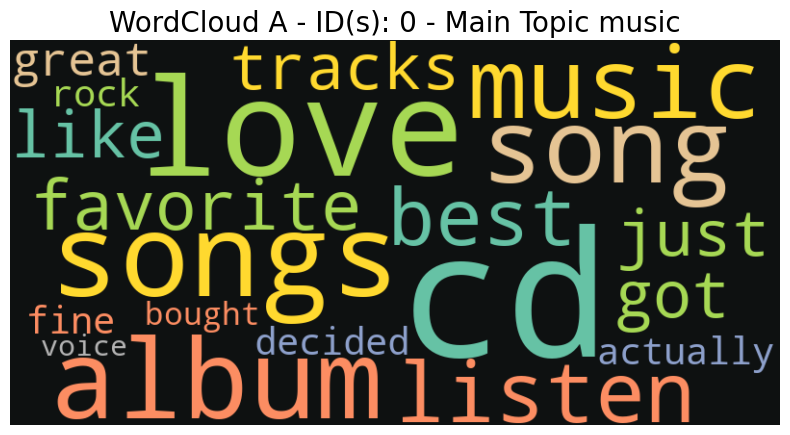

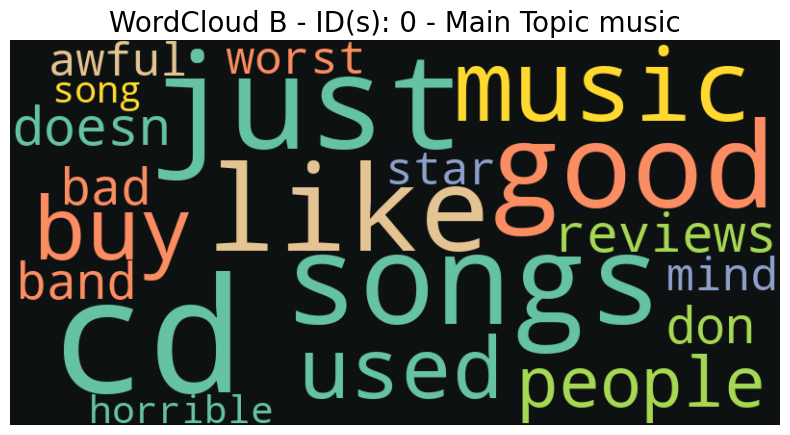

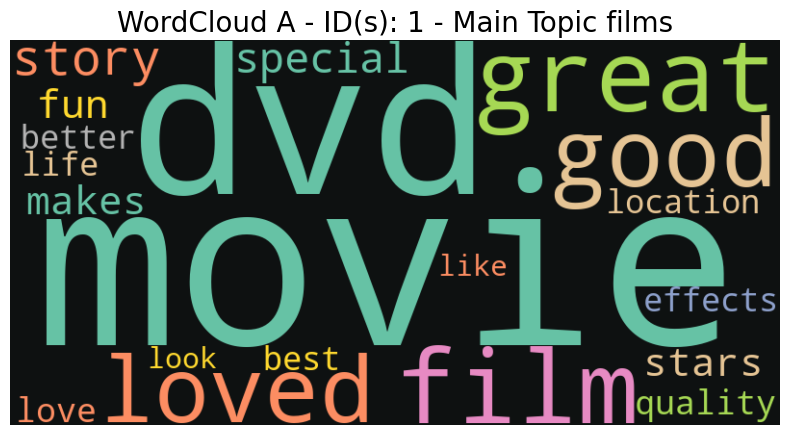

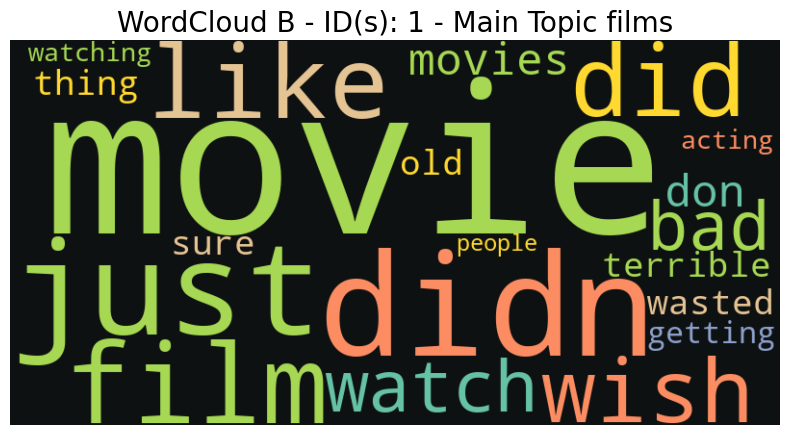

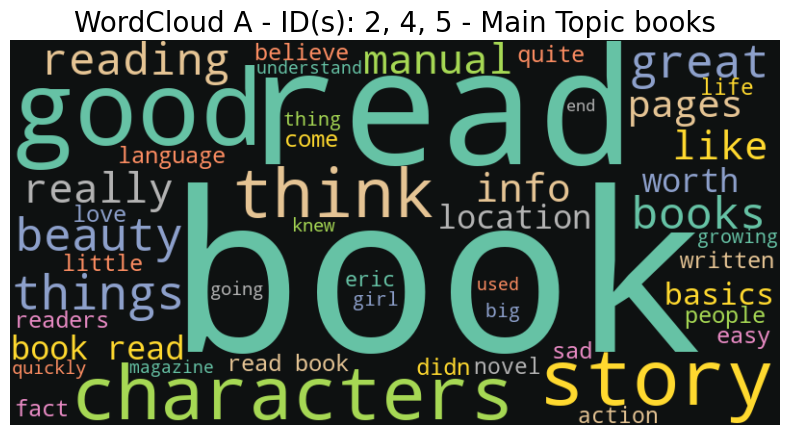

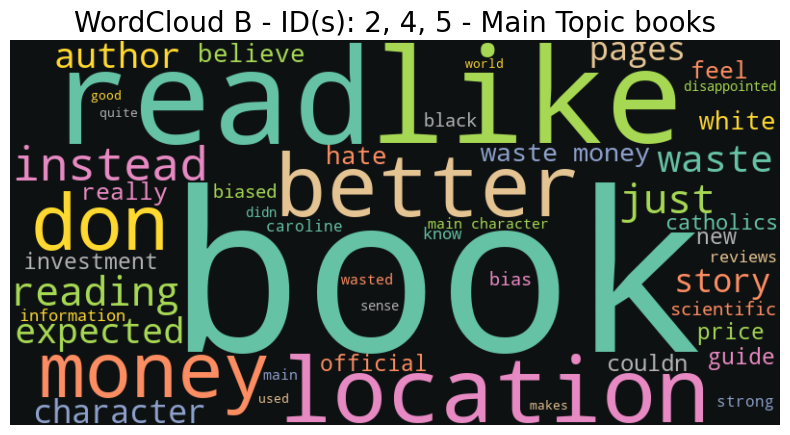

In [392]:
cluster_groups = [[0], [1], [2, 4, 5]]
cluster_labels = ["music", "films", "books"]

for i in range(len(cluster_groups)):
    clusters = cluster_groups[i]
    cluster_label = cluster_labels[i]
    temp_cluster_info_A = cluster_info_A[cluster_info_A["Cluster"].isin(clusters)].copy()
    temp_cluster_info_B = cluster_info_B[cluster_info_B["Cluster"].isin(clusters)].copy()
    str_clusters = [str(cluster) for cluster in clusters]

    representation = "Top_Words_TFIDF" # "Top_Words" or "Top_Words_TFIDF"
    if len(clusters) == 1:
        combined_representation_A = temp_cluster_info_A[representation].values.tolist()[0]
        combined_representation_B = temp_cluster_info_B[representation].values.tolist()[0]
    else:
        combined_representation_A = combine_word_representation_from_cluster(temp_cluster_info_A[representation].values.tolist())
        combined_representation_B = combine_word_representation_from_cluster(temp_cluster_info_B[representation].values.tolist())

    plot_wordcloud(combined_representation_A, title=f"WordCloud A - ID(s): {', '.join(str_clusters)} - Main Topic {cluster_label}", fname=f"wordcloud_A_{cluster_label}")
    plot_wordcloud(combined_representation_B, title=f"WordCloud B - ID(s): {', '.join(str_clusters)} - Main Topic {cluster_label}", fname=f"wordcloud_B_{cluster_label}")

##### 1.5 Compute and plot centroid drifts from A -> B

In [262]:
get_x = lambda x: np.nan if not isinstance(x, (list, tuple, np.ndarray)) or len(x) < 1 else x[0]
get_y = lambda x: np.nan if not isinstance(x, (list, tuple, np.ndarray)) or len(x) < 2 else x[1]

In [263]:
# fig = go.Figure()

# fig.add_trace(
#     go.Scatter(
#         x=data_A["2D_embeddings"].apply(get_x),
#         y=data_A["2D_embeddings"].apply(get_y),
#         mode='markers',
#         name='Period A - Doc. Embeddings',
#         marker=dict(size=5, color=data_A["cluster"], colorscale="Ice"),
#         text=data_A['cluster'],
#         customdata=["A"] * len(data_A),
#         hovertemplate="Period A - Cluster %{text}<extra></extra>",
#     )
# )

# fig.add_trace(
#     go.Scatter(
#         x=data_B["2D_embeddings"].apply(get_x),
#         y=data_B["2D_embeddings"].apply(get_y),
#         mode='markers',
#         name='Period B - Doc. Embeddings',
#         marker=dict(size=5, color=data_B["cluster"], colorscale="Solar"),
#         text=data_B['cluster'],
#         customdata=["B"] * len(data_B),
#         hovertemplate="Period B - Cluster %{text}<extra></extra>",
#     )
# )

# fig.add_trace(
#     go.Scatter(
#         x=cluster_info_A['2D_Centroid'].apply(get_x),
#         y=cluster_info_A['2D_Centroid'].apply(get_y),
#         mode='markers',
#         name='Period A - Topic Centroids',
#         marker=dict(size=12, color=cluster_info_A["Cluster"], colorscale="Ice"),
#         text=cluster_info_A['Cluster'],
#         customdata=["A"] * len(cluster_info_A),
#         hovertemplate="Period A - Cluster %{text}<extra></extra>",
#     )
# )

# fig.add_trace(
#     go.Scatter(
#         x=cluster_info_B['2D_Centroid'].apply(get_x),
#         y=cluster_info_B['2D_Centroid'].apply(get_y),
#         mode='markers',
#         name='Period B - Topic Centroids',
#         marker=dict(size=12, color=cluster_info_B["Cluster"], colorscale="Solar"),
#         text=cluster_info_B['Cluster'],
#         customdata=["B"] * len(cluster_info_B),
#         hovertemplate="Period B - Cluster %{text}<extra></extra>",
#     )
# )

# compute_on = "2D_Centroid" # "Centroid" or "2D_Centroid"
# drifts = {}
# for idx, row in cluster_info_B.iterrows():
#     cluster_id = row['Cluster']
#     if cluster_id in cluster_info_A['Cluster'].values:
#         centroid_A = cluster_info_A[cluster_info_A['Cluster'] == cluster_id][compute_on].values[0]
#         centroid_B = row[compute_on]
#         drift = centroid_B - centroid_A
#         drifts[cluster_id] = centroid_B - centroid_A

#         centroid_A_2D = cluster_info_A[cluster_info_A['Cluster'] == cluster_id]["2D_Centroid"].values[0]
#         centroid_B_2D = row["2D_Centroid"]
#         fig.add_trace(
#             go.Scatter(
#                 x=[get_x(centroid_A_2D), get_x(centroid_B_2D)],
#                 y=[get_y(centroid_A_2D), get_y(centroid_B_2D)],
#                 mode='markers+lines',
#                 marker=dict(
#                     symbol="arrow",
#                     size=10,
#                     angleref="previous",
#                     color="red",
#                 ),
#                 text=f"Topic {cluster_id}",
#                 name=f'A -> B Drift for Topic {cluster_id}',
#                 showlegend=True,
#             )
#         )
#     else:
#         drifts[cluster_id] = np.nan

# fig.layout.update(
#     title="Topic Clusters and Document Embeddings",
#     showlegend=True,
#     legend=dict(font=dict(size=12), orientation="h", x=0, y=-0),
#     hovermode='closest',
#     margin=dict(l=0, r=0, t=30, b=0),
#     width=1000,
#     height=800,
# )

# fig.show()

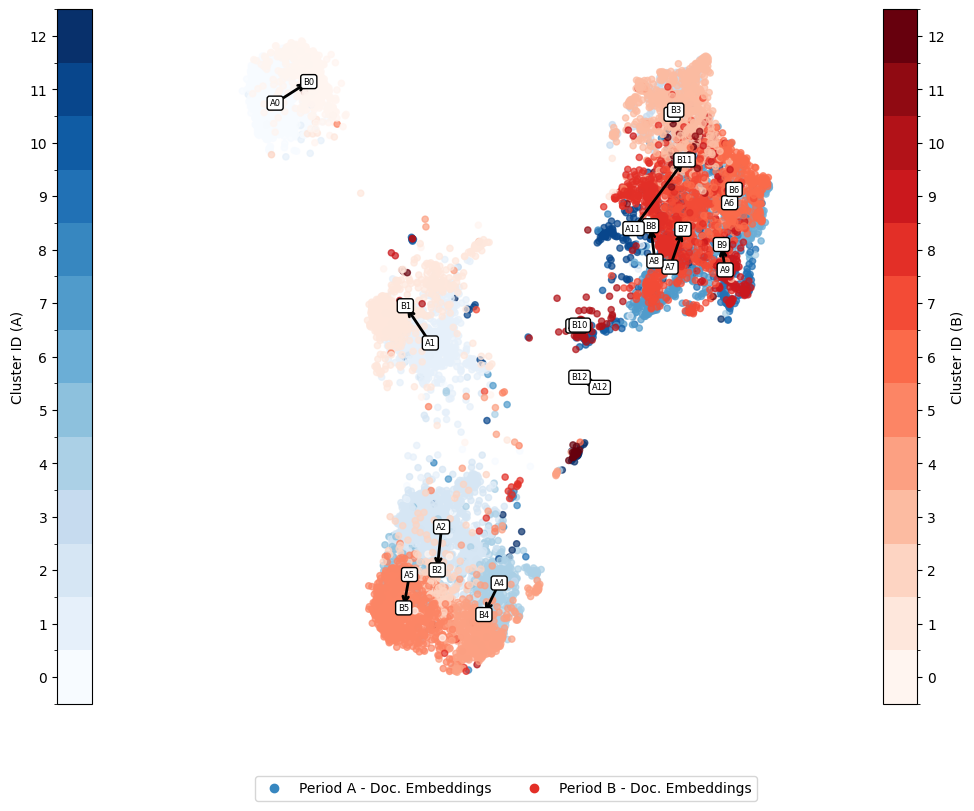

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8), layout="constrained")

all_labels = np.unique(labels).tolist()
total_clusters = len(all_labels)
a_color = mpl.colormaps['Blues'].resampled(total_clusters)
b_color = mpl.colormaps['Reds'].resampled(total_clusters)
norm_A = mcolors.BoundaryNorm(boundaries=np.arange(total_clusters + 1) - 0.5, ncolors=total_clusters)
norm_B = mcolors.BoundaryNorm(boundaries=np.arange(total_clusters + 1) - 0.5, ncolors=total_clusters)

# --- Plot document embeddings ---
# Period A
scatter_A = ax.scatter(
    data_A["2D_embeddings"].apply(get_x),
    data_A["2D_embeddings"].apply(get_y),
    c=data_A["cluster"],
    cmap=a_color,
    s=20,
    label="Period A - Doc. Embeddings",
    alpha=0.7
)

# Period B
scatter_B = ax.scatter(
    data_B["2D_embeddings"].apply(get_x),
    data_B["2D_embeddings"].apply(get_y),
    c=data_B["cluster"],
    cmap=b_color,
    s=20,
    label="Period B - Doc. Embeddings",
    alpha=0.7
)

# --- Plot drift arrows ---
compute_on = "2D_Centroid"
drifts = {}
for idx, row in cluster_info_B.iterrows():
    cluster_id = row['Cluster']
    if cluster_id in cluster_info_A['Cluster'].values:
        centroid_A_2D = cluster_info_A[cluster_info_A['Cluster'] == cluster_id]["2D_Centroid"].values[0]
        centroid_B_2D = row["2D_Centroid"]
        start_x, start_y = get_x(centroid_A_2D), get_y(centroid_A_2D)
        end_x, end_y = get_x(centroid_B_2D), get_y(centroid_B_2D)
        ax.annotate("" xy=(end_x, end_y), xytext=(start_x, start_y), arrowprops=dict(arrowstyle="->", color="black", lw=2))
        drifts[cluster_id] = np.array(centroid_B_2D) - np.array(centroid_A_2D)
    else:
        drifts[cluster_id] = np.nan

# --- Add text labels for clusters ---
for idx, row in cluster_info_A.iterrows():
    cluster_id = row['Cluster']
    centroid_A_2D = cluster_info_A[cluster_info_A['Cluster'] == cluster_id]["2D_Centroid"].values[0]
    centroid_B_2D = cluster_info_B[cluster_info_B['Cluster'] == cluster_id]["2D_Centroid"].values[0]
    start_x, start_y = get_x(centroid_A_2D), get_y(centroid_A_2D)
    end_x, end_y = get_x(centroid_B_2D), get_y(centroid_B_2D)
    ax.text(
        start_x, start_y, # Start point
        f"A{cluster_id}", fontsize=6, ha="center", va="center", color="black",
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
    )
    ax.text(
        end_x, end_y, # End point
        f"B{cluster_id}", fontsize=6, ha="center", va="center", color="black",
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
    )

# --- Add color bar ---
cbar_A = fig.colorbar(
    ScalarMappable(norm=norm_A, cmap=a_color), ax=ax, orientation="vertical", location="left", pad=0.15, ticks=all_labels
); cbar_A.set_label("Cluster ID (A)", fontsize=10)
cbar_B = fig.colorbar(
    ScalarMappable(norm=norm_B, cmap=b_color), ax=ax, orientation="vertical", location="right", pad=0.15, ticks=all_labels
); cbar_B.set_label("Cluster ID (B)", fontsize=10)

# --- Final styling ---
legend_dot_A = mlines.Line2D([], [], color='#3787c0', marker='o', linestyle='None', markersize=6, label='Period A - Doc. Embeddings')
legend_dot_B = mlines.Line2D([], [], color='#e32f27', marker='o', linestyle='None', markersize=6, label='Period B - Doc. Embeddings')
ax.legend(handles=[legend_dot_A, legend_dot_B], loc="lower center", bbox_to_anchor=(0.5, -0.15), ncol=2)
ax.set_xticks([]); ax.set_yticks([])
ax.set_frame_on(False)
plt.savefig("images/topic_embedding_drift_amazon_plot.pdf", format="pdf", bbox_inches='tight')
plt.show()

**Interesting:**
- 0: music, CD, songs
- 1: film, DVD, video
- 2, 4, 5: books
- 3, 6, 7, 8, 10: Products
- 9: video games, games
- 11: workout video/DVD
- 12: kindle, books

##### 1.6 Unit drifts clustering

In [265]:
drifts_df = pd.DataFrame.from_dict(drifts, orient='index', columns=['x', 'y']).dropna()
# drifts_df = pd.DataFrame.from_dict(drifts, orient='index').dropna()
drifts_df.index.name = "Cluster"

# Normalize drift vectors to unit length
unit_drifts = normalize(drifts_df.dropna().values, norm='l2')

k = 4
# Compute angles in radians
angles = np.arctan2(unit_drifts[:, 1], unit_drifts[:, 0])   # range [-pi, pi]
angles = (angles + 2 * np.pi) % (2 * np.pi)                 # convert to [0, 2pi]
sector_size = 2 * np.pi / k                                 # Define number of angular sectors
labels = np.floor(angles / sector_size).astype(int)         # Assign each angle to a sector
drifts_df["labels"] = labels

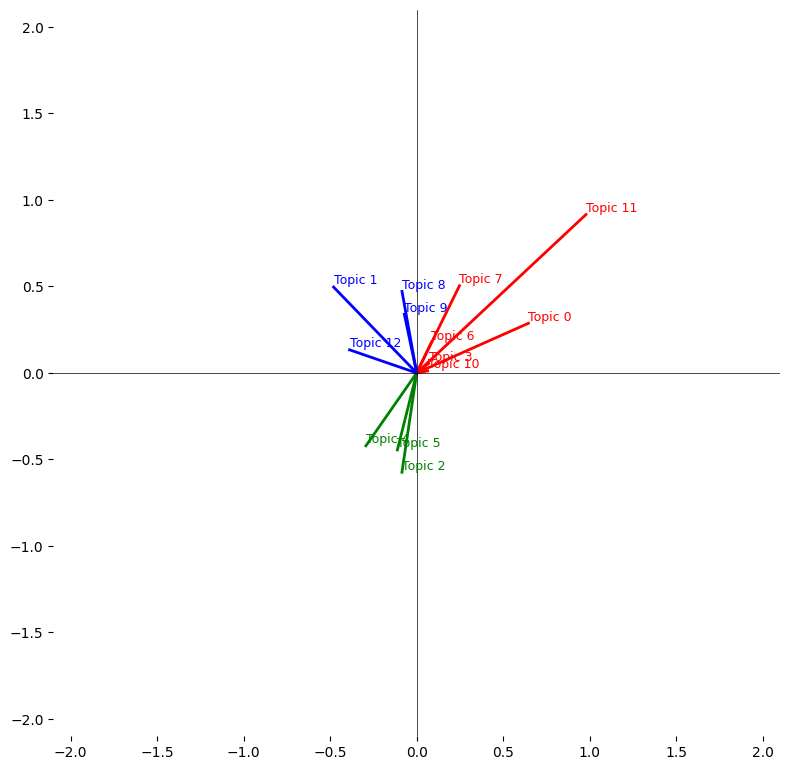

In [266]:
fig, ax = plt.subplots(figsize=(8, 10))

colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink', 'brown', 'gray']
for topic_id, row in drifts_df.iterrows():
    x, y, label_id = row['x'], row['y'], int(row['labels'])
    color = colors[label_id]
    ax.plot([0, x], [0, y], color=color, linewidth=2, label=f"Topic {topic_id}")
    ax.text(x, y, f"Topic {topic_id}", fontsize=9, color=color, ha='left', va='bottom')

# lim = drifts_df[['x', 'y']].abs().max().max() 
# label_positions = [[lim,lim], [-lim, lim], [-lim, -lim], [lim, -lim]]
# for label in np.unique(labels):
#     x = label_positions[label][0]
#     y = label_positions[label][1]
#     ax.text(x, y,
#         f"Cluster {label}", fontsize=10, color=colors[label], ha='center', va='center',
#         bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
#     )

lim = 2.1
ax.set_aspect('equal', 'box')
ax.set_xlim(-lim, lim); ax.set_ylim(-lim, lim)
ax.axhline(0, color='black', linewidth=0.5); ax.axvline(0, color='black', linewidth=0.5)
# ax.set_xticks([]); ax.set_yticks([])
ax.set_frame_on(False)
fig.tight_layout()

fig.savefig("images/unit_drift_vectors_amazon.pdf", format="pdf", bbox_inches="tight")
plt.show()

##### 1.7.1 Interpretation per cluster of drift

In [267]:
# cluster_topics = [3]
for cluster_id in range(k):
    cluster_topics = drifts_df[drifts_df['labels'] == cluster_id].index.tolist()
    temp_cluster_info_A = cluster_info_A[cluster_info_A['Cluster'].isin(cluster_topics)]
    temp_cluster_info_B = cluster_info_B[cluster_info_B['Cluster'].isin(cluster_topics)]

    # Get the most frequent words in the cluster
    topic_representation = "Top_Words_TFIDF" # "Top_Words"
    words_A = list(chain(*temp_cluster_info_A[topic_representation]))
    words_B = list(chain(*temp_cluster_info_B[topic_representation]))
    common_words = list(set(words_A) & set(words_B))
    new_words = list(set(words_B) - set(words_A))
    print(f"{len(new_words)} new words in unit drift cluster {cluster_id} (from {len(words_A)} words)")
    print(f"Common words: {common_words}")
    print(f"Words added by B: {new_words}")
    print()

68 new words in unit drift cluster 0 (from 120 words)
Common words: ['like', 'player', 'screen', 'good', 'buy', 'does', 'watch', 'model', 'songs', 'product', 'cd', 'bought', 'use', 'game', 'music', 'quality', 'don', 've', 'people', 'great', 'song', 'thing', 'money', 'just', 'toy', 'daughter', 'got', 'games']
Words added by B: ['mouth', 'fell apart', 'set', 'issue', 'watches', 'winder', 'useless', 'son', 'reviews', 'parts', 'apart', 'blank', 'wand', 'right', 'heavy', 'long', 'replacement', 'control', 'analog', 'maker', 'worst', 'plastic', 'told', 'awful', 'legs', 'started', 'problem', 'products', 'away', 'machine', 'major', 'certain', 'tools', 'change', 'thought', 'playing', 'polar', 'warranty', 'bad', 'poor', 'doesn', 'mind', 'horrible', 'sonic', 'hard', 'sirius', 'customer', 'garbage', 'used', 'read', 'batteries', 'work', 'unit', 'band', 'sent', 'went', 'worked', 'graphics', 'service', 'trick', 'coffee', 'star', 'really', 'battery', 'support', 'fell', 'better', 'water']

57 new words 

##### 1.7.2 Interpretation per topic cluster

In [268]:
for cluster_id in cluster_info_A["Cluster"]:
    row_A = cluster_info_A[cluster_info_A["Cluster"] == cluster_id].iloc[0]
    row_B = cluster_info_B[cluster_info_B["Cluster"] == cluster_id].iloc[0]

    representation = "Top_Words_TFIDF" # "Top_Words"
    words_A = row_A[representation]
    words_B = row_B[representation]
    common_words = list(set(words_A) & set(words_B))
    print(f"Cluster {cluster_id}:")
    print("Common words:", common_words)
    print("Exclusive A words:", list(set(words_A) - set(common_words)))
    print("Exclusive B words:", list(set(words_B) - set(common_words)))
    print()

Cluster 0:
Common words: ['like', 'song', 'music', 'just', 'songs', 'cd']
Exclusive A words: ['voice', 'best', 'decided', 'love', 'actually', 'great', 'rock', 'album', 'bought', 'listen', 'favorite', 'tracks', 'got', 'fine']
Exclusive B words: ['reviews', 'mind', 'awful', 'people', 'horrible', 'star', 'good', 'used', 'buy', 'don', 'worst', 'band', 'bad', 'doesn']

Cluster 1:
Common words: ['movie', 'film', 'just']
Exclusive A words: ['special', 'makes', 'love', 'dvd', 'good', 'quality', 'story', 'effects', 'life', 'look', 'best', 'stars', 'great', 'fun', 'better', 'loved', 'location']
Exclusive B words: ['like', 'acting', 'wish', 'movies', 'old', 'don', 'watch', 'didn', 'terrible', 'getting', 'wasted', 'did', 'thing', 'sure', 'watching', 'funny', 'bad']

Cluster 2:
Common words: ['book']
Exclusive A words: ['girl', 'love', 'pages', 'quickly', 'read book', 'read', 'story', 'growing', 'eric', 'knew', 'think', 'thing', 'characters', 'book read', 'things', 'books', 'reading', 'big', 'going

In [269]:
cluster_id = 0 # 0, 2, 5, 6 are very good candidate clusters to study
row_A = cluster_info_A[cluster_info_A["Cluster"] == cluster_id].iloc[0]
row_B = cluster_info_B[cluster_info_B["Cluster"] == cluster_id].iloc[0]

representation = "Top_Words_TFIDF" # "Top_Words"
words_A = row_A[representation]
words_B = row_B[representation]
common_words = list(set(words_A) & set(words_B))
print(f"Cluster {cluster_id}:")
print("Common words:", common_words)
print("Exclusive A words:", list(set(words_A) - set(common_words)))
print("Exclusive B words:", list(set(words_B) - set(common_words)))
print()

Cluster 0:
Common words: ['like', 'song', 'music', 'just', 'songs', 'cd']
Exclusive A words: ['voice', 'best', 'decided', 'love', 'actually', 'great', 'rock', 'album', 'bought', 'listen', 'favorite', 'tracks', 'got', 'fine']
Exclusive B words: ['reviews', 'mind', 'awful', 'people', 'horrible', 'star', 'good', 'used', 'buy', 'don', 'worst', 'band', 'bad', 'doesn']



In [270]:
row_A.Top_Representative_Docs

['A Great CD!! I just brouth the cd DATE and i have played it non-stop since i got it. I heard of ORGANIZATION before i got the cd but i never really heard anything from them. I had burned a cd with one of the songs from this album for one of my friends and i really liked the song so i decided to get the cd if i ever found it. Sowhen i found it i was thinking if i should get this CD or another one that was in my hand. I decided this CD and im damn sure happy i did. I think all the songs are great nd id say Hit or Miss and Boy Crazy are my favorite songs on the CD. Since i got it though i have not stoped playing it and i enjoy playing it cause when i am under the weather this is a godd CD to listen to to bring me back up so i say anyone should get this cd no matter hwat you listen to cause i myself love hardrock more than anything but this would have to be on top of my list of cds.',
 "ORGANIZATION I was in the music store sometime back and was browsing. All of a sudden, my attention wa

In [271]:
row_B.Top_Representative_Docs

['NUM well crafted songs does NOT make a great cd Sorry folks, I hate to burst everyone\'s bubble - But this release is just not that good. I have listened to this off and on for DATE, waiting for most of the songs to catch on, and what I have found is that most of the cuts are to \'noise orientated\' and sloppy. Songs that are plain awful are \'Bomb\', \'ORGANIZATION\', \'Monkey\', and \'Alien\'. To much "whining" from the lead singer and not a mealody to be found from the guitarist ! I call this a dirty trick, figuring that this is the same group that came up with excellent songs such as \'Everything Zen\' and \'Comedown\'. These songs show so much craftsmanship that I would expect the same from all (or most) of the songs. It just doesn\'t happen ! Figuring \'Razorblade Suitcase\' and \'Deconstructed\' are failures for this band - I think we will be seeing them in DATE on ORGANIZATION\'s WHERE ARE THEY NOW segments.',
 "New meaning to Ripped off Well, reading through these reviews, I